In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import datetime
import json
import time

plt.style.use('..\\personal_plot.mplstyle')

### Conditions

In [44]:
# The first item ever posted on Hacker News, ID number 1
# https://news.ycombinator.com/item?id=1, dated October 9th, 2006
# 
# up to now, so every month from October 2006 to now (October 2018)

first_date = datetime.datetime(year = 2006, month = 10, day = 1)
last_date  = datetime.datetime(year = 2018, month = 11, day = 1)

# get information for the following years and months
years  = np.linspace(2006, 2018, 13, dtype = int)
months = np.linspace(1, 12, 12, dtype = int)
days   = np.linspace(1, 31, 31, dtype = int)
hours  = [0, 12]
dates  = []

# we are only interested in the domain between first_date and last_date, others are omitted
for year in years:
    for month in months:
        for day in days:
            for hour in hours:
                try:
                    date = datetime.datetime(year = year, month = month, day = day, hour = hour)

                    if date >= first_date and date <= last_date:
                        dates.append(date)
                except ValueError:
                    continue

### Define functions

In [45]:
def strip_url(url):
    # Ask HN can be without URL, check this first
    if url:
        # Remove https:// or http://
        if url.find("https://") == -1:
            url = url[7:-1]
        else:
            url = url[8:-1]

        # Remove www.
        if url.find("www.") != -1:
            url = url[4:]
            
        # Remove end bits
        if url.find("/") != -1:
            url = url[:url.find("/")]
         
    # If no URL specified, add a string    
    else:
        url = "No url"
    
    return url

In [46]:
def get_stories(start_date, end_date):
    # Using =, > and < is not possible with python requests custom headers
    # so this is done hardcoded into the request string
    # the hitsPerPage is required because otherwise the results are scatered over a number of pages
    algolia_link = "https://hn.algolia.com/api/v1/search_by_date?tags=story&numericFilters=created_at_i>" \
                   + start_date + ",created_at_i<" + end_date + "&hitsPerPage=1000"

    req = None
    
    while req == None:
        try:
            req = requests.get(algolia_link)
        except:
            time.sleep(1)
    
    req_json = json.loads(req.text)
    
    return req_json

In [47]:
def parse_top(json):
    # the objects per post that we are interested in
    objectID = []
    points = []
    created = []
    story_url = []
    num_comments = []

    # save all interesting objects
    for item in json["hits"]:
        objectID.append(item["objectID"])
        points.append(item["points"])
        story_url.append(strip_url(item["url"]))
        num_comments.append(item["num_comments"])
        
        creation_date = datetime.datetime.strptime(item["created_at"][:-5], '%Y-%m-%dT%H:%M:%S')
        created.append(creation_date)
    
    if objectID:
        year = creation_date.year
        month = creation_date.month

        date_from = int(time.mktime(datetime.datetime(year = year, 
                                                      month = month, 
                                                      day = 1).timetuple()))

        if int(month) != 12:
            date_to = int(time.mktime(datetime.datetime(year = year, 
                                                        month = month + 1, 
                                                        day = 1).timetuple()))
        else:
            date_to = int(time.mktime(datetime.datetime(year = year + 1, 
                                                        month = 1, 
                                                        day = 1).timetuple()))

        # save the lists of interesting objects into a dataframe
        dataframe = pd.DataFrame.from_dict({"ID": objectID,
                                            "Points": points,
                                            "Created": created,
                                            "URL": story_url,
                                            "Comments": num_comments,
                                            "date_from": date_from,
                                            "date_to": date_to})

        # sort the objects by number of points
        dataframe = dataframe.sort_values(by = "Points", ascending = False).reset_index()

        # return the top5
        return dataframe.drop(labels = "index", axis = 1).head()

### Get information

In [48]:
%%time

# we are going to scrape between two dates, so we need not the full length of the dates list
for i in range(len(dates) -1):
    from_date = str(int(time.mktime(dates[i].timetuple())))
    to_date   = str(int(time.mktime(dates[i + 1].timetuple())))
    
    if i == 0:
        print(datetime.datetime.time(datetime.datetime.now()), dates[i].year)
    else:
        if dates[i].year != dates[i - 1].year:
            print(datetime.datetime.time(datetime.datetime.now()), dates[i].year)
    
    posts = get_stories(from_date, to_date)
    posts_df = parse_top(posts)
    
    try:
        if dates[i] == first_date:
            dataframe = posts_df
        else:
            dataframe = pd.concat([dataframe, posts_df])
    except:
        continue 
    
    time.sleep(1)

15:50:42.692868 2006
15:55:18.779934 2007
16:15:36.145932 2008
16:36:19.404000 2009
16:56:52.863876 2010
17:17:43.975097 2011
17:38:50.212753 2012
18:01:17.666751 2013
18:24:36.366639 2014
18:46:50.530654 2015
19:10:07.176845 2016
19:34:24.924926 2017
19:56:28.647824 2018
Wall time: 4h 25min 6s


In [49]:
# reset the index of the dateframe
dataframe = dataframe.reset_index()
dataframe.drop(labels = "index", axis = 1)

# save dataframe to csv
dataframe.to_csv("Posts/HackerNewsPosts.csv")

### Analyse information
#### Highest 5 posts per month

In [50]:
# The first item ever posted on Hacker News, ID number 1
# https://news.ycombinator.com/item?id=1, dated October 9th, 2006
# 
# up to now, so every month from October 2006 to now (February 2018)

first_date = datetime.datetime(year = 2006, month = 10, day = 1)
last_date  = datetime.datetime(year = 2019, month = 2, day = 1)

# get information for the following years and months
years  = np.linspace(2006, 2019, 14, dtype = int)
months = np.linspace(1, 12, 12, dtype = int)
days   = np.linspace(1, 31, 31, dtype = int)
dates = []

# we are only interested in the domain between first_date and last_date, others are omitted
for year in years:
    for month in months:
        date = datetime.datetime(year = year, month = month, day = 1)

        if date >= first_date and date <= last_date:
            dates.append(date)

In [51]:
top5_posts = pd.read_csv("Posts/HackerNewsPosts.csv")

created = top5_posts["Created"]
datetime_created = []

for creation in created:
    datetime_created.append(datetime.datetime.strptime(creation, '%Y-%m-%d %H:%M:%S'))
    
top5_posts["Created"] = datetime_created
top5_posts.head()

,Unnamed: 0,index,ID,Points,Created,URL,Comments,date_from,date_to
0,0,0,1,61,2006-10-09 18:21:51,ycombinator.co,18,1159653600,1162335600
1,1,1,2,16,2006-10-09 18:30:28,paulgraham.com,1,1159653600,1162335600
2,2,2,16,11,2006-10-09 19:51:43,feld.com,1,1159653600,1162335600
3,3,3,8,10,2006-10-09 19:17:39,news.bbc.co.uk,0,1159653600,1162335600
4,4,4,20,8,2006-10-09 20:00:38,avc.blogs.com,3,1159653600,1162335600


In [52]:
date_point = []
avg_points = []
min_points = []
max_points = []

for i in range(len(dates) -1):
    temp_df = top5_posts.loc[(top5_posts["Created"] > dates[i]) & (top5_posts["Created"] < dates[i + 1])]
    
    # return the top5 per month
    temp_df = temp_df.sort_values(by = "Points", ascending = False).reset_index()
    temp_df = temp_df.drop(labels = "index", axis = 1).head()
    
    if len(temp_df.index) > 0:
        date_point.append(dates[i])
        avg_points.append(np.average(temp_df["Points"]))
        min_points.append(np.min(temp_df["Points"]))
        max_points.append(np.max(temp_df["Points"]))

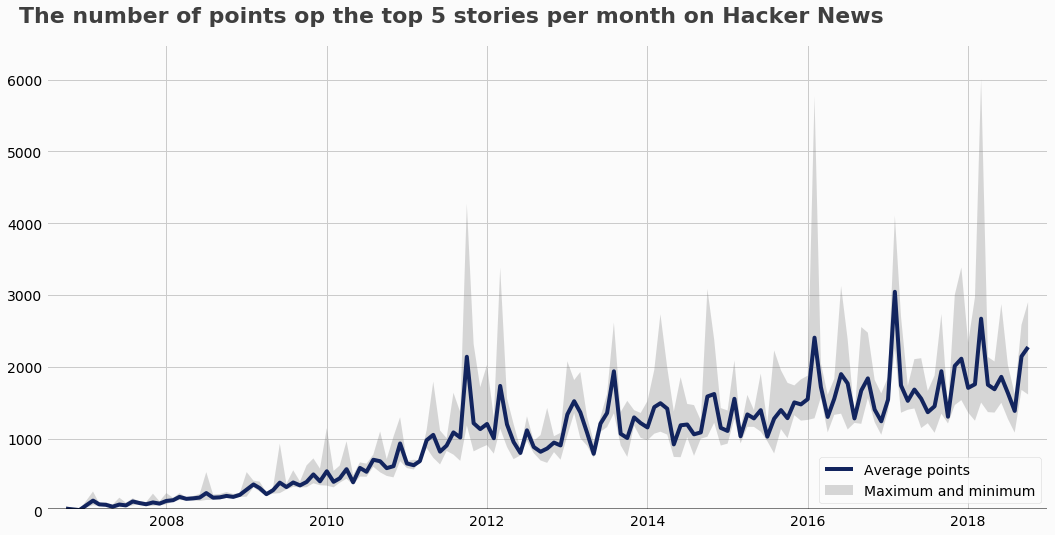

In [53]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(date_point, avg_points, label = "Average points")
ax.fill_between(date_point, min_points, max_points, facecolor = "grey", alpha = 0.3, label = "Maximum and minimum")
ax.set_xlim([datetime.datetime(year = 2006, month = 7, day = 1), datetime.datetime(year = 2018, month = 12, day = 31)])
ax.set_ylim([0, 6500])
ax.legend(loc = "lower right")

ax.axhline(y = 0, color = 'black', alpha = 0.5)

plt.text(x = datetime.datetime(2006, 3, 1), 
         y = 6800, 
         s = "The number of points op the top 5 stories per month on Hacker News",
         fontsize = 22, weight = 'bold', alpha = .75)

plt.savefig("..\\..\\uijl.github.io_blog\\figures\\hacker-news-blog-top5-stories-per-month.png", bbox_inches = "tight")
plt.show()

#### Most used sources for top 5 posts per month day

In [54]:
# we now want the top5 for every day, not every month
dates = []

for year in years:
    for month in months:
        try:
            for day in days:
                date = datetime.datetime(year = year, month = month, day = day)

                if date >= first_date and date <= last_date:
                    dates.append(date)
        except:
            continue

In [55]:
sources = []

for i in range(len(dates) -1):
    temp_df = top5_posts.loc[(top5_posts["Created"] > dates[i]) & (top5_posts["Created"] < dates[i + 1])]
    
    # return the top5 per month
    temp_df = temp_df.sort_values(by = "Points", ascending = False).reset_index()
    temp_df = temp_df.drop(labels = "index", axis = 1).head()
    
    if len(temp_df.index) > 0:        
        for url in temp_df["URL"]:
            sources.append(url)

sources = pd.DataFrame({"URL": sources})

In [56]:
top_sources = sources["URL"].value_counts()

top_sources_url  = top_sources[:15].index
top_sources_hits = top_sources[:15].values

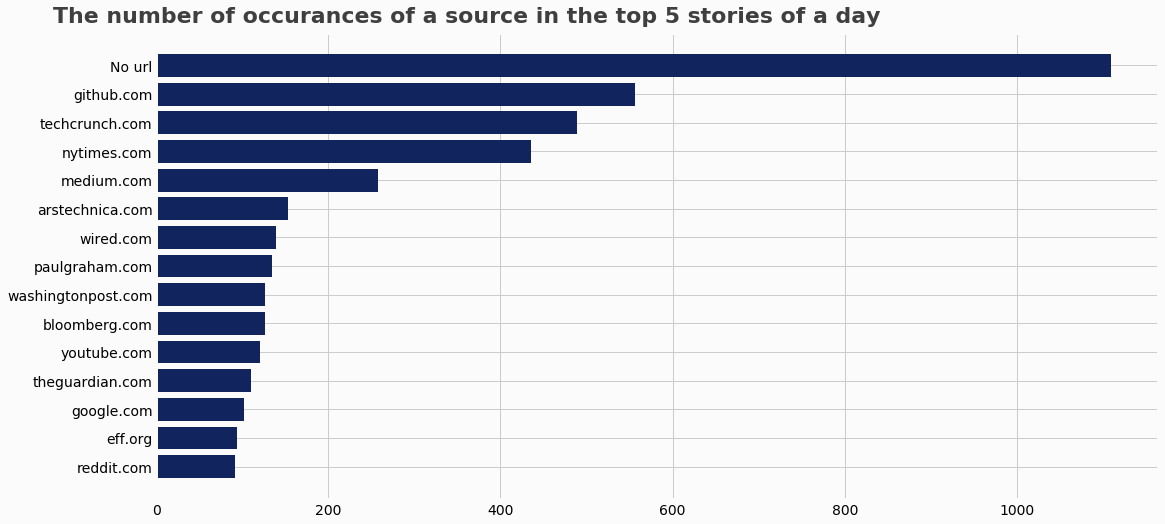

In [57]:
fig, ax = plt.subplots(figsize=(16, 8))

y_pos = np.arange(len(top_sources_url))

ax.barh(y_pos, top_sources_hits, align = "center")
ax.set_yticks(y_pos)
ax.set_yticklabels(top_sources_url)
ax.invert_yaxis() 

plt.text(x = -120, 
         y = -1.5, 
         s = "The number of occurances of a source in the top 5 stories of a day",
         fontsize = 22, weight = 'bold', alpha = .75)

plt.savefig("..\\..\\uijl.github.io_blog\\figures\\hacker-news-blog-top-sources-per-month.png", bbox_inches = "tight")
plt.show()

#### Only publishers

In [58]:
# assume that bbc.com and bbc.co.uk run the same stories
top_sources["bbc.co.uk"] = top_sources["bbc.co.uk"] + top_sources["bbc.com"]
top_sources = top_sources.sort_values(ascending = False)

top_sources = top_sources.drop(["No url", 
                                "github.com", 
                                "medium.com", 
                                "youtube.com", 
                                "eff.org", 
                                "en.wikipedia.org", 
                                "paulgraham.com",
                                "bbc.com",
                                "google.com", 
                                "reddit.com",
                                "plus.google.com",
                                "twitter.com",
                                "groups.google.com",
                                "37signals.com",
                                "code.google.com",
                                "codinghorror.com",
                                "googleblog.blogspot.com"])

top_sources_url  = top_sources[:15].index
top_sources_hits = top_sources[:15].values

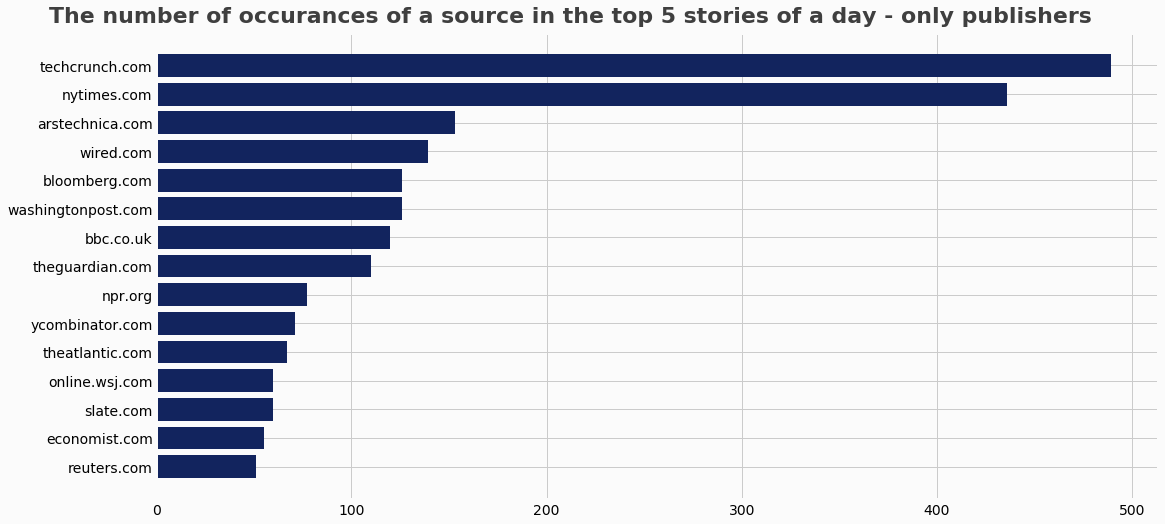

In [59]:
fig, ax = plt.subplots(figsize=(16, 8))

y_pos = np.arange(len(top_sources_url))

ax.barh(y_pos, top_sources_hits, align = "center")
ax.set_yticks(y_pos)
ax.set_yticklabels(top_sources_url)
ax.invert_yaxis() 

plt.text(x = -55, 
         y = -1.5, 
         s = "The number of occurances of a source in the top 5 stories of a day - only publishers",
         fontsize = 22, weight = 'bold', alpha = .75)

plt.savefig("..\\..\\uijl.github.io_blog\\figures\\hacker-news-blog-top-publishers-per-month.png", bbox_inches = "tight")
plt.show()